<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 28px; color: black; font-weight: bold;">
Basics on integrating ODE, adjoint method, etc.
</div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything()

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float32)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Lorenz attractor (3D) - solving with scipy.integrate.solve_ivp
</div>

Assume the following ODE (Lorenz attractor)

\begin{align}
    \begin{matrix}
        \frac{dx}{dt} \\ \frac{dy}{dt} \\ \frac{dz}{dt}
    \end{matrix} &=
    \begin{matrix}
        \sigma \left( y(t) - x(t) \right) \\
        \rho x(t) - y(t) - x(t)z(t) \\
        x(t)y(t) - \beta z(t)
    \end{matrix}
\end{align}

with $\sigma, \rho, \beta > 0$.

In [4]:
sigma = 10
beta = 8/3
rho = 28

def func(t, vec):
    # signature of func must be func(t, y)
    x, y, z = vec
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return x_dot, y_dot, z_dot

x0 = [1.0, 1.0, 1.0]

t_start = 0.0
t_end = 40.0
t_span = (t_start, t_end)

In [5]:
from scipy.integrate import solve_ivp
import numpy as np

t_eval = np.linspace(t_start, t_end, 10000)

sol = solve_ivp(func, t_span, x0, t_eval=t_eval)

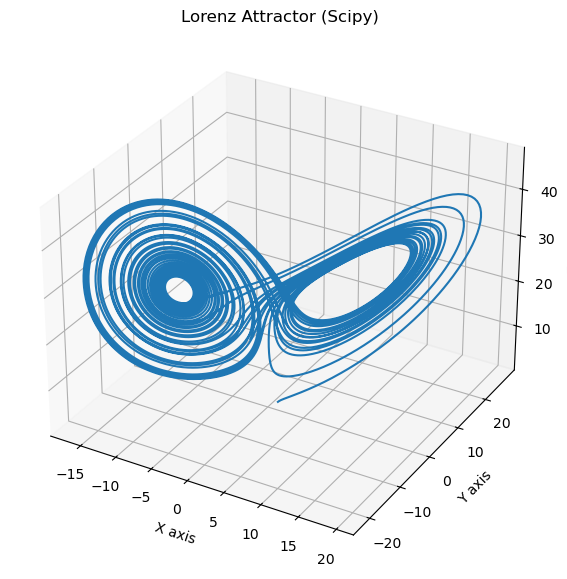

In [6]:
# plot results in 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 7))
ax.plot(sol.y[0], sol.y[1], sol.y[2])
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.set_title("Lorenz Attractor (Scipy)")
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Homemade solver with RK4 - poor man's version : no adaptative time step, no error checking
</div>

In [7]:
def t_func(t, vec):
    # signature of func must be func(t, y)
    x, y, z = vec[0], vec[1], vec[2]
    x_dot = sigma * (y - x)
    y_dot = x * (rho - z) - y
    z_dot = x * y - beta * z
    return torch.stack([x_dot, y_dot, z_dot])

In [8]:
def t_solve_ivp(func, t_span, x0, nsteps=10000, method='RK4'):
    """
    Home made ODE solver to work with tensors.
    Inputs:
        - func : function of the ODE, signature func(t, y)
            - t : float
            - y : tensor of shape (n,)
        - t_span : tuple of floats (t0, tf), starting and end times
        - x0 : tensor of shape (n,), staring value
    """
    t_start, t_end = t_span
    dt = (t_end - t_start) / nsteps
    t = t_start
    ts = [t_start + i*dt for i in range(nsteps+1)]
    xs = [x0.clone().to(device)]
    dxs = []
    x = x0.clone().to(device).requires_grad_(True)
    
    assert method in ['Euler', 'RK4'], "Method must be 'Euler' or 'RK4'"

    for _ in range(nsteps):
        if method == 'Euler':
            # Euler step
            dx = func(t, x)
            x = x + dx * dt
            t = t + dt
        elif method == 'RK4':
            # Runge Kutta 4th order step
            k1 = func(t, x)
            k2 = func(t + dt/2, x + dt/2 * k1)
            k3 = func(t + dt/2, x + dt/2 * k2)
            k4 = func(t + dt, x + dt * k3)
            dx = dt/6 * (k1 + 2*k2 + 2*k3 + k4)
            x = x + dx
            t = t + dt
        xs.append(x)
        dxs.append(dx)
        
    _ = xs.pop(-1)  # remove final point to match length of ts
    ts = torch.tensor(ts, dtype=torch.float32, requires_grad=True).to(device)
    sols = torch.stack(xs)
    grads = torch.stack(dxs)
        
    return ts, sols, grads

In [9]:
x0 = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float, requires_grad=True)
ts, sols, grads =  t_solve_ivp(t_func, t_span, x0, nsteps=1000, method='RK4')

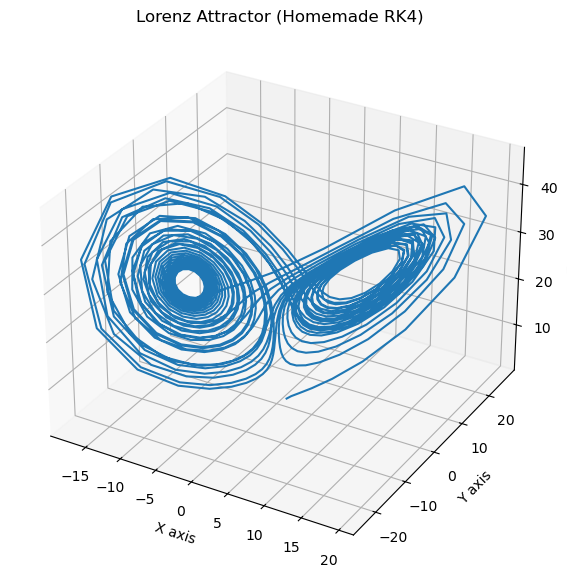

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 7))
ax.plot(
    sols[:,0].detach().cpu().numpy(), 
    sols[:,1].detach().cpu().numpy(), 
    sols[:,2].detach().cpu().numpy()
)
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
ax.set_title("Lorenz Attractor (Homemade RK4)")
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
2D spiral
</div>

In [11]:
def func_spiral(t, vec, mu=0.01):
    # signature of func must be func(t, y)
    x, y = vec
    x_dot = mu * x - y - x * (x**2 + y**2)
    y_dot = x + mu * y - y * (x**2 + y**2)
    return torch.stack([x_dot, y_dot])

In [12]:
x0 = torch.tensor([2.0, 0.0], dtype=torch.float, requires_grad=True)
t_span = (0.0, 20.0)
ts, sols, grads =  t_solve_ivp(func_spiral, t_span, x0, nsteps=100, method='RK4')

In [13]:
def plot_trajectory_2D(ts, sols, grads, interval=5, title="2D Trajectory"):
    fig, ax = plt.subplots(figsize=(6,6))

    X,Y = sols[:,0].detach().cpu().numpy(), sols[:,1].detach().cpu().numpy()
    U,V = grads[:,0].detach().cpu().numpy(), grads[:,1].detach().cpu().numpy()
    scale = 1e-0
    interval = 5

    ax.plot(X,Y, label='Trajectory')
    ax.plot(X[0], Y[0], 'go', label='Start')
    ax.plot(X[-1], Y[-1], 'ro', label='End')
    ax.quiver(X[::interval], Y[::interval], U[::interval], V[::interval], angles='xy', scale_units='xy', scale=scale, alpha=0.5, label='Vector Field')
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_title(title)
    ax.grid(True)
    plt.show()

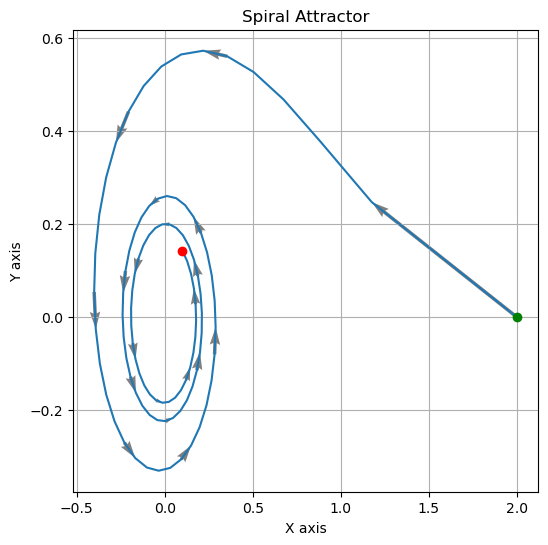

In [14]:
plot_trajectory_2D(ts, sols, grads, title="Spiral Attractor")

In [15]:
targets = sols.clone().detach().to(device)

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Learning the gradient flow function with a MLP. Using a L2 loss on *trajectories*, not gradients
</div>

Checking that a simple MLP can learn a gradient function.

We use a L2 loss on trajectories, meaning that we backpropagate through the ODE solver.

In [16]:
class ODENet(nn.Module):
    def __init__(self, n=32):
        super(ODENet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, n),
            nn.Tanh(),
            nn.Linear(n, n),
            nn.Tanh(),
            nn.Linear(n, n),
            nn.Tanh(),
            nn.Linear(n, 2)
        )
    def forward(self, x):
        return self.net(x)
    
ode_net = ODENet(n=64).to(device)

In [17]:
def t_func_net(t, vec):
    return ode_net(vec)

In [18]:
n_epochs = 1300
optimizer = torch.optim.Adam(ode_net.parameters(), lr=1e-3)

for epoch in range(n_epochs):
    # at each epoch, we solve the ODE with the current neural network
    optimizer.zero_grad()
    ts_net, sols_net, grads_net =  t_solve_ivp(t_func_net, t_span, x0, nsteps=100, method='RK4')
    # we compute the loss between the target trajectory and the predicted one
    loss = (targets - sols_net).pow(2).mean()
    # and we backpropagate the loss through the ODE solver (which is NOT a good practice !)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1:<6} -- {n_epochs:<6}, Loss: {loss.item():.6f}", end="\r")

In [19]:
ts_net, sols_net, grads_net =  t_solve_ivp(t_func_net, t_span, x0, nsteps=100, method='RK4')

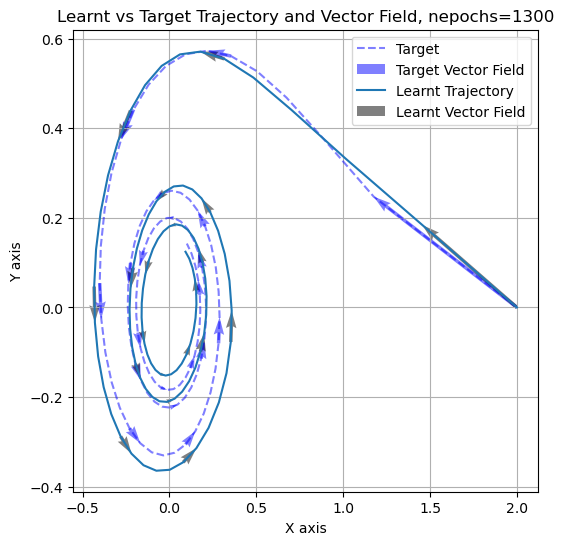

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
    
scale = 1e-0
interval = 5
    
# targets
Xt,Yt = targets[:,0].detach().cpu().numpy(), targets[:,1].detach().cpu().numpy()
ax.plot(Xt, Yt, 'b--', label='Target', alpha=0.5)
Ut,Vt = grads[:,0].detach().cpu().numpy(), grads[:,1].detach().cpu().numpy()
ax.quiver(Xt[::interval], Yt[::interval], Ut[::interval], Vt[::interval], angles='xy', scale_units='xy', scale=scale, color='blue', alpha=0.5, label='Target Vector Field')

# modèle
X,Y = sols_net[:,0].detach().cpu().numpy(), sols_net[:,1].detach().cpu().numpy()
ax.plot(X,Y, label='Learnt Trajectory')
U,V = grads_net[:,0].detach().cpu().numpy(), grads_net[:,1].detach().cpu().numpy()
# ax.plot(X[0], Y[0], 'go', label='Start')
# ax.plot(X[-1], Y[-1], 'ro', label='End')
ax.quiver(X[::interval], Y[::interval], U[::interval], V[::interval], angles='xy', scale_units='xy', scale=scale, alpha=0.5, label='Learnt Vector Field')
    
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.grid(True)
ax.legend()
ax.set_title(f"Learnt vs Target Trajectory and Vector Field, nepochs={n_epochs:.0f}")
plt.show()

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
The adjoint method
</div>

- Solve the $\textbf{initial value problem}$ with an ODE solver:
                $\begin{align}
                    \frac{dx}{dt} &= f_{\theta}(x,t) \\
                    x(t=0) &= x_0
                \end{align}$
- Solve the $\textbf{adjoint/terminal value problem}$ with an ODE solver:
                $\begin{align}
                    \frac{d \lambda}{dt} + \left( \frac{\partial f}{\partial x}\right)^{T} \lambda(t) + \left( \frac{\partial g}{\partial x}\right)^{T} &= 0 \\
                    \lambda(T) &= 0
                \end{align}$
- Compute the gradient:
                $\begin{align}
                    \frac{dJ}{d \theta} &= \int_{0}^{T} \left( \frac{\partial g}{\partial \theta} + \lambda^{T}(t) \frac{\partial f}{\partial \theta} \right) dt
                        + \lambda(0) \frac{df\vert_0}{d\theta}
                \end{align}$

Shapes !

<div style="background-color: #008B8B; padding: 15px; border-radius: 5px; font-size: 20px; color: black; font-weight: bold;">
Preliminary work before running the adjoint method
</div>

1- How are the parameters of the neural network organized ? The adjoint method allows to compute gradients outside the backward() function

2- Once we have computed the gradients, how do we pass them to the optimizer.step() ?

In [21]:
ode_net = ode_net.to(device)

for k, param in ode_net.state_dict().items():
    print(f"name = {k} \t shape = {param.shape} \t requires_grad = {param.requires_grad}")

name = net.0.weight 	 shape = torch.Size([64, 2]) 	 requires_grad = False
name = net.0.bias 	 shape = torch.Size([64]) 	 requires_grad = False
name = net.2.weight 	 shape = torch.Size([64, 64]) 	 requires_grad = False
name = net.2.bias 	 shape = torch.Size([64]) 	 requires_grad = False
name = net.4.weight 	 shape = torch.Size([64, 64]) 	 requires_grad = False
name = net.4.bias 	 shape = torch.Size([64]) 	 requires_grad = False
name = net.6.weight 	 shape = torch.Size([2, 64]) 	 requires_grad = False
name = net.6.bias 	 shape = torch.Size([2]) 	 requires_grad = False


### 3- Form adjoint ODE:

\begin{align}
    \frac{d\lambda}{dt} &= - \left( \frac{\partial f}{\partial u} \right)^T \lambda + \left( \frac{\partial g}{\partial u} \right)^T
\end{align}